# Titanic: Neural network optimization

# Table of contents

1. [Introduction](#1.-Introduction)
2. [Import data](#2.-Import-data)
3. [Exploratory data analysis](#3.-Exploratory-data-analysis)
4. [Feature engineering](#4.-Feature-engineering)
5. [Hyperparameters tuning](#5.-Hyperparameters-tuning)
6. [Conclusions and further developments](#6.-Conclusions-and-further-developments)

# 1. Introduction

The objective of the Kaggle competition [Titanic: Machine Learning from Disaster](https://www.kaggle.com/c/titanic) is to develop machine learning models to predict which passengers survived the shipwreck. This notebook focus on feature engineering and hyperparameter tuning. If you have further ideas to improve this notebook or anything you don’t understand, please leave a comment.

# 2. Import data

In [1]:
%reset -f

# Import modules
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.neural_network import MLPClassifier
import sys
from utils import *

mpl.rcParams.update({'font.size': 13})
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=wong_colors.values())

print('Python version', sys.version.split()[0])

Python version 3.8.7


In [2]:
# Import training and test sets
folder = './'
# folder = '/kaggle/input/titanic/'

train = pd.read_csv(folder + 'train.csv')
test = pd.read_csv(folder + 'test.csv')

print('Training set shape:', train.shape)
print('Test set shape:', test.shape)

# Convert columns names to lowercase
train.columns = train.columns.str.lower()
test.columns = test.columns.str.lower()

Training set shape: (891, 12)
Test set shape: (418, 11)


In [3]:
train.head()

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


The columns of this DataFrame are:

* `passengerid` - Unique identifier of each passenger (used for submissions).
* `survived` - Whether the passenger survived or not (0=No, 1=Yes).
* `pclass` - The class of the ticket the passenger purchased (1=1st, 2=2nd, 3=3rd).
* `name` - Name of the passenger.
* `sex` - The passenger's sex.
* `age` - The passenger's age in years.
* `sibsp` - The number of siblings or spouses the passenger had aboard the Titanic.
* `parch` - The number of parents or children the passenger had aboard the Titanic.
* `ticket` - The passenger's ticket number.
* `fare` - The fare the passenger paid.
* `cabin` - The passenger's cabin number.
* `embarked` - The port where the passenger embarked (C=Cherbourg, Q=Queenstown, S=Southampton).

Both sets have 11 features. The extra column of the training set is the target variable `survived`.

# 3. Exploratory data analysis

Now let’s look at the columns’ data types and the number of missing values.

In [4]:
pd.concat([train, test]).describe()

,passengerid,survived,pclass,age,sibsp,parch,fare
count,1309.000000,891.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000
mean,655.000000,0.383838,2.294882,29.881138,0.498854,0.385027,33.295479
std,378.020061,0.486592,0.837836,14.413493,1.041658,0.865560,51.758668
min,1.000000,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,328.000000,0.000000,2.000000,21.000000,0.000000,0.000000,7.895800
50%,655.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,982.000000,1.000000,3.000000,39.000000,1.000000,0.000000,31.275000
max,1309.000000,1.000000,3.000000,80.000000,8.000000,9.000000,512.329200


We can see that:

* Only 38.4% of the passengers survived;
* The age ranges from 0.17 to 80;
* Some columns have missing values (missing values of column `survived` are from the test set).

In [5]:
df_info(train)

,Null count,Dtype
passengerid,0,int64
survived,0,int64
pclass,0,int64
name,0,object
sex,0,object
age,177,float64
sibsp,0,int64
parch,0,int64
ticket,0,object
fare,0,float64


In [6]:
df_info(test)

,Null count,Dtype
passengerid,0,int64
pclass,0,int64
name,0,object
sex,0,object
age,86,float64
sibsp,0,int64
parch,0,int64
ticket,0,object
fare,1,float64
cabin,327,object


The columns' data types seem to be correct, but the following columns have missing values:

* `age` and `cabin` of both datasets
* `embarked` of the training set
* `fare` of the test set

We will fill the two missing values of the column embarked with the mode.

In [7]:
train.loc[train['embarked'].isnull(), 'embarked'] = train['embarked'].mode()[0]

Regarding the missing fare value, we will assign the mean value.

In [8]:
test.loc[test['fare'].isnull(), 'fare'] = test['fare'].mean()

The columns `age` and `cabin` have too many missing values and will not be used. Now let's plot our data.

In [9]:
def plot_discrete_feature(train, feature):

    survived = train.groupby(feature)['survived'].mean() * 100
    x = range(len(survived))

    _, axs = plt.subplots(1, 2, figsize=(14,5))

    plt.sca(axs[0])
    plt.bar(x, train.groupby(feature)['survived'].size())
    plt.ylabel('N. of passengers')

    plt.sca(axs[1])
    plt.bar(x, survived)
    plt.bar(x, 100 - survived, bottom=survived)
    plt.ylabel('Survival percentage')
    plt.legend(['Survived', 'Not survived'], loc='upper left', bbox_to_anchor=(1, 1), frameon=False)

    
    for ax in axs:
        set_spines_vis(ax=ax)      
        ax.set_xticks(x)
        ax.set_xticklabels(survived.index)
        ax.set_xlabel(feature)

In [10]:
def plot_continuous_feature(train, feature, binwidth):

    plt.figure(figsize=(10,5))
    sns.histplot(train, x=feature, hue='survived', binwidth=binwidth, legend=False)
    plt.legend(['Survived', 'Not survived'], frameon=False)
    set_spines_vis()

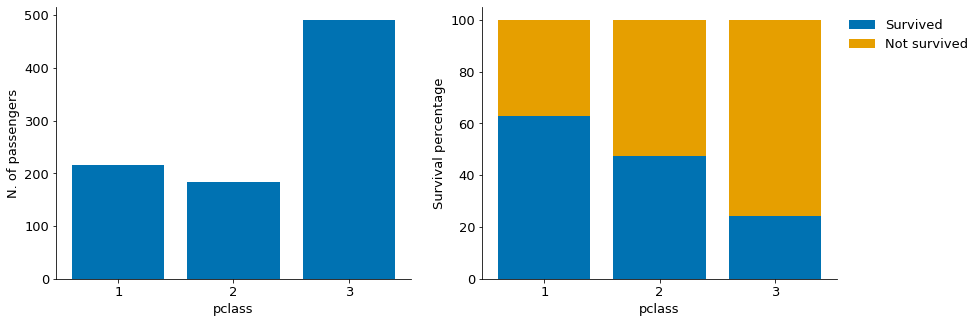

In [11]:
plot_discrete_feature(train, 'pclass')

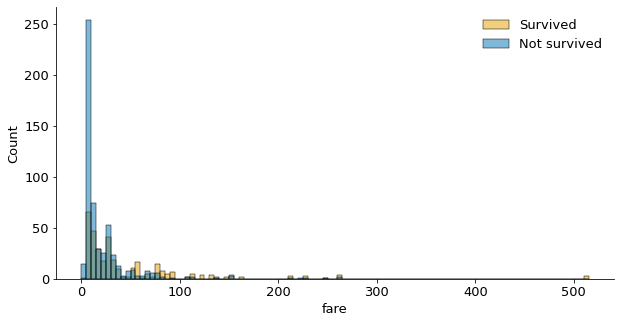

In [12]:
plot_continuous_feature(train, 'fare', 5)

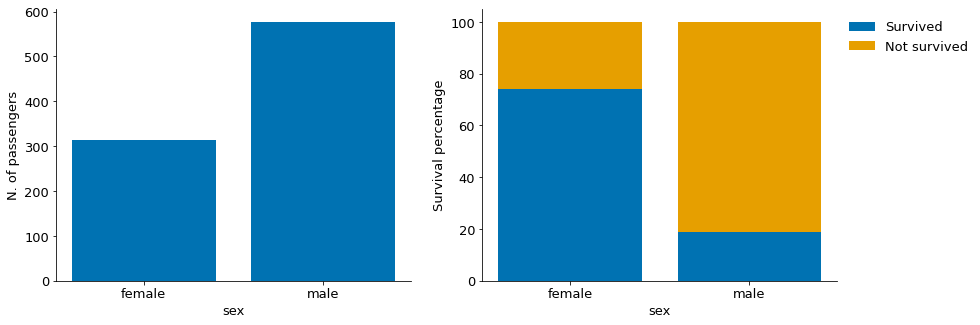

In [13]:
plot_discrete_feature(train, 'sex')

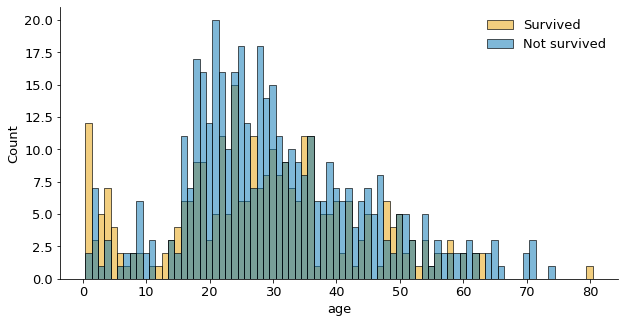

In [14]:
plot_continuous_feature(train, 'age', 1)

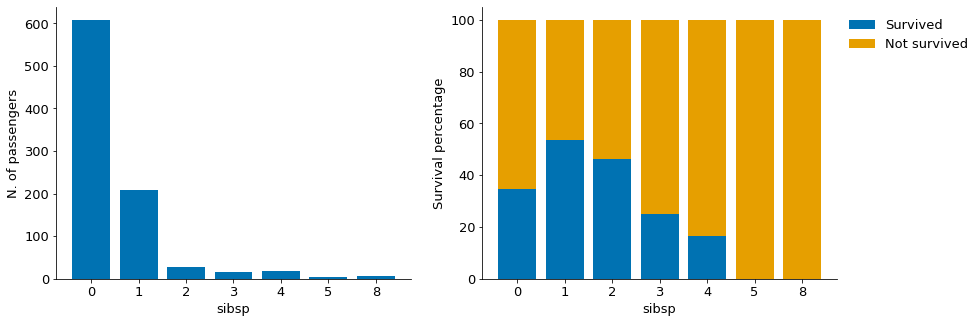

In [15]:
plot_discrete_feature(train, 'sibsp')

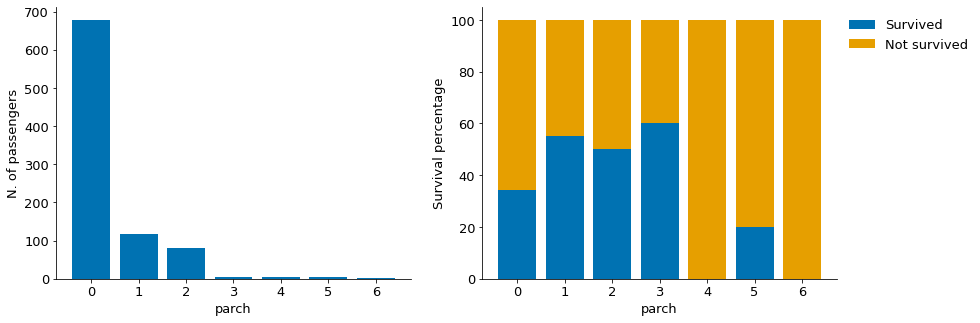

In [16]:
plot_discrete_feature(train, 'parch')

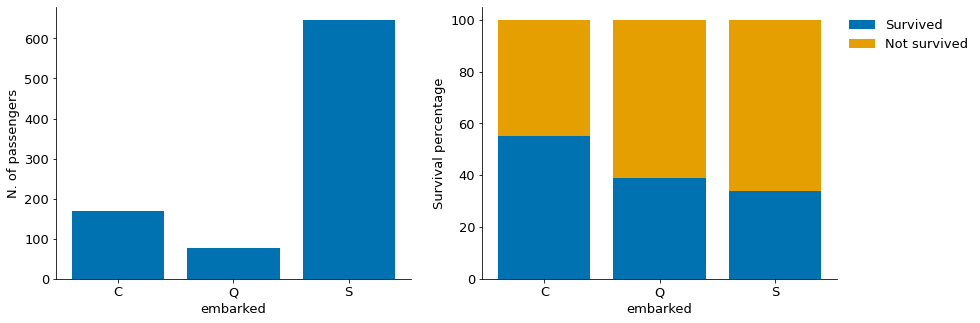

In [17]:
plot_discrete_feature(train, 'embarked')

We can observe that:

* Passengers with upper-class tickets had better chances of survival than the rest;
* Females survived in much higher proportion than males;
* People younger than five had more chances of surviving, while the rest did not;
* Passengers with no family members or with a lot of members have fewer chances of surviving;
* Passengers with lower fares had worse chances of survival;
* The port where the passenger embarked seems to influence the chances of survival.

The fare seems to capture the same information as the ticket class, and hence it will not be used. The columns `pclass`, `sex` and `embarked` are categorical features. Although the column `pclass` is numeric, there is not a numeric relationship between the different values. For instance, class 3 is not the triple of class 1. Most machine learning algorithms cannot understand text labels, and so we have to convert our values into numbers. The pandas function [get_dummies](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html) turns each categorical feature into a series of zeros and ones.

In [18]:
def get_dummies(train, test, columns):

    # Concatenate training and test sets
    df = pd.concat([train[columns], test[columns]])

    # Convert categorical variables into dummy variables
    df = pd.get_dummies(df)

    X_train = df.iloc[:train.shape[0]]
    X_test = df.iloc[train.shape[0]:]

    return X_train, X_test

In [19]:
train['pclass'] = train['pclass'].astype('category')
test['pclass'] = test['pclass'].astype('category')

features = ['pclass', 'sex', 'sibsp', 'parch', 'embarked']
X_train, X_test = get_dummies(train, test, features)

y_train = train['survived']

We will use the Scikit-learn [MLPClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html) class to predict if the passengers survived or not and the utility function **sklearn_fit_eval** to evaluate and validate our model.

In [20]:
create_params = {'max_iter':1000, 'random_state':0, 'hidden_layer_sizes': 5}
clf = MLPClassifier(**create_params)

sklearn_fit_eval(clf, {'X':X_train, 'y':y_train}, cv=5);

Train accuracy: 79.24%; Validation accuracy: 79.35%; Fitting time: 0.36s


We got a validation accuracy of 79.35%. Now let’s calculate the predictions for the test set.

In [21]:
def save_submission(y, passenger, filename):
    submission = pd.DataFrame({'PassengerId':passenger,'Survived':y})
    submission.to_csv(filename, index=False)

save_submission(clf.predict(X_test), test['passengerid'], 'submission_5.csv')

The test set predictions were submitted to Kaggle, and an accuracy of 77.03% was obtained.

# 4. Feature engineering

Feature engineering is the process of transforming raw data into features that better represent the underlying problem and enable more accurate predictive models. We will start with the column `name`.

In [22]:
train['name'].sample(10)

341      Fortune, Miss. Alice Elizabeth
90                 Christmann, Mr. Emil
476             Renouf, Mr. Peter Henry
15     Hewlett, Mrs. (Mary D Kingcome) 
520               Perreault, Miss. Anne
433          Kallio, Mr. Nikolai Erland
510            Daly, Mr. Eugene Patrick
138                 Osen, Mr. Olaf Elon
706       Kelly, Mrs. Florence "Fannie"
453            Goldenberg, Mr. Samuel L
Name: name, dtype: object

The title of each name might be useful information. We will create a new column with this.

In [23]:
titles = train['name'].str.extract(' ([A-Za-z]+)\.', expand=False)
titles.unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'Countess',
       'Jonkheer'], dtype=object)

We have too many unique values, which might lead to overfitting. We will group these titles into the categories `Mr`, `Mrs`, `Master`, `Miss`, `Officer` and `Royalty`.

In [24]:
titles_map = {'Mr': 'Mr', 'Master': 'Master'}
titles_map.update(dict.fromkeys(['Mrs', 'Ms', 'Mme', 'Ms'], 'Mrs'))
titles_map.update(dict.fromkeys(['Miss', 'Mlle'], 'Miss'))
titles_map.update(dict.fromkeys(['Capt', 'Col', 'Major', 'Dr', 'Rev'], 'Officer'))
titles_map.update(dict.fromkeys(['Jonkheer', 'Don', 'Sir', 'Countess', 'Dona', 'Lady'], 'Royalty'))

def extract_title(df):
    df['title'] = df['name'].str.extract(' ([A-Za-z]+)\.', expand=False).map(titles_map)
    
extract_title(train)
extract_title(test)

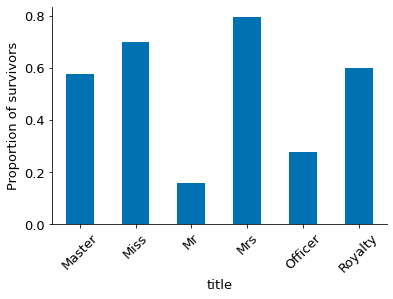

In [25]:
train.groupby('title')['survived'].mean().plot.bar(rot=45, ylabel='Proportion of survivors')
set_spines_vis()

The survival chances of a passenger might be correlated with those of the rest of the family. To extract the families, we assume that if passengers share the same surname and have a similar ticket, they belong to the same family. Tickets are considered to be identical if their last digit is the same.

In [26]:
def extract_family(df):
    surname = df['name'].str.extract('(.+?), ', expand=False)
    df['family'] = surname + '_' + df['ticket'].str[:-1]

extract_family(train)
extract_family(test)

families_intersection = set(train['family']) & set(test['family'])
print('Number of families contained in both sets:', len(families_intersection))

train.loc[~train['family'].isin(families_intersection), 'family'] = np.nan
test.loc[~test['family'].isin(families_intersection), 'family'] = np.nan

Number of families contained in both sets: 107


Let's calculate our model's accuracy with the additional features `title` and `family`.

In [27]:
features = ['pclass', 'sex', 'sibsp', 'parch', 'embarked', 'title', 'family']
X_train, X_test = get_dummies(train, test, features)

clf = MLPClassifier(**create_params)

sklearn_fit_eval(clf, {'X':X_train, 'y':y_train}, cv=5);

Train accuracy: 86.20%; Validation accuracy: 82.71%; Fitting time: 0.84s


The validation accuracy increased from 79.35% to 82.71%. Now we will predict which passengers of the test set survived.

In [28]:
save_submission(clf.predict(X_test), test['passengerid'], 'submission_6.csv')

The test set predictions were submitted to Kaggle, and an accuracy of 77.99% was obtained.

# 5. Hyperparameters tuning

We can also try different combinations of hyperparameters to improve performance. Although several hyperparameters for each model were tunned, only those that led to a considerable improvement are shown. The utility function **sklearn_plot_losses** is used to compare the loss curves.


Value: 0.00010; Loss: 0.34; Fitting time: 2.86s
Value: 0.00046; Loss: 0.30; Fitting time: 2.02s
Value: 0.00215; Loss: 0.29; Fitting time: 1.19s
Value: 0.01000; Loss: 0.29; Fitting time: 0.62s


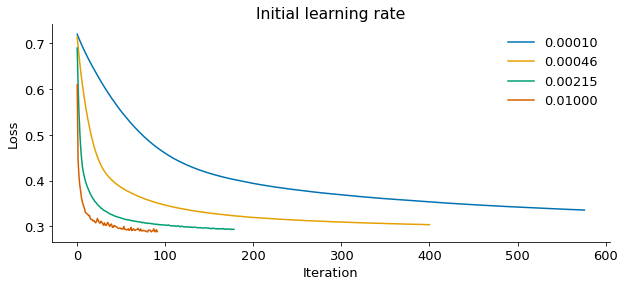

In [29]:
# Tune the initial learning rate
vals = list(np.logspace(-4, -2, 4))
create_params = {'max_iter':1000, 'random_state':0, 'learning_rate_init':vals}
fit_params = {'X':X_train, 'y':y_train}

sklearn_plot_losses(MLPClassifier, create_params, fit_params, ['{:.5f}'.format(val) for val in vals])
plt.title('Initial learning rate');

Value: 128; Loss: 0.30; Fitting time: 1.04s
Value: 256; Loss: 0.29; Fitting time: 1.76s
Value: 512; Loss: 0.29; Fitting time: 1.05s


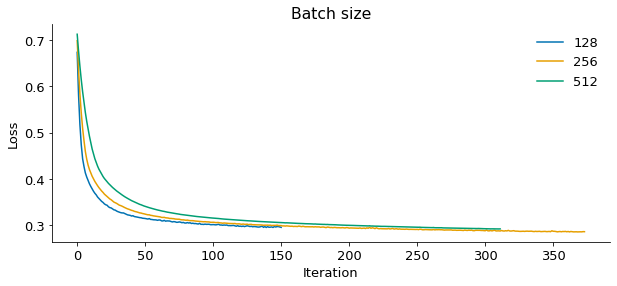

In [30]:
create_params['learning_rate_init'] = 0.002

# Tune the batch size
create_params['batch_size'] = [128, 256, 512]

sklearn_plot_losses(MLPClassifier, create_params, fit_params)
plt.title('Batch size');

We will now use the utility function **plot_models_metrics** to compare the training and validation accuracies and training times.

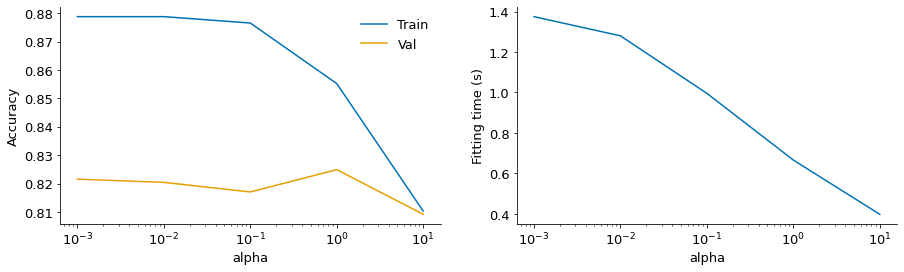

In [31]:
create_params['batch_size'] = 256
create_params['alpha'] = list(np.logspace(-3, 1, 5))
fit_eval_params = {'fit_params': fit_params, 'cv': 5, 'verbose': False}

plot_models_metrics(MLPClassifier, create_params, sklearn_fit_eval, fit_eval_params, axes_params={'xscale': 'log'})

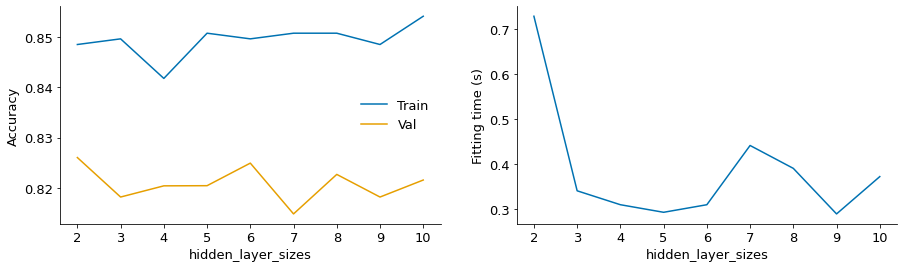

In [32]:
create_params['alpha'] = 1

# Tune the hidden layer sizes
create_params['hidden_layer_sizes'] = list(range(2, 11))
fit_eval_params = {'fit_params': fit_params, 'cv': 5, 'verbose': False}

plot_models_metrics(MLPClassifier, create_params, sklearn_fit_eval, fit_eval_params)

Let's calculate our model's accuracy with the optimised hyperparameters and predict which passengers of the test set survived.

In [33]:
create_params['hidden_layer_sizes'] = 6

clf = MLPClassifier(**create_params)

sklearn_fit_eval(clf, {'X':X_train, 'y':y_train}, cv=5);

Train accuracy: 84.96%; Validation accuracy: 82.49%; Fitting time: 0.39s


In [34]:
save_submission(clf.predict(X_test), test['passengerid'], 'submission_7.csv')

The test set predictions were submitted to Kaggle, and an accuracy of 80.86% was obtained.

# 6. Conclusions and further developments

This notebook uses neural networks to predict which passengers survived the Titanic shipwreck. It explores how feature engineering and hyperparameter optimization influences the accuracy of our model. The best model is 80.86% accurate. To further improve our model, we can:

* Read more about the titanic and this Kaggle competition to get ideas for new features.
* Use different models such as support vector machines or gradient boosted trees.

Also, there are several other excellent notebooks related to this competition. Thanks for reading my notebook and any comments and suggestions are very welcome.